In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset",)

print("Path to dataset files:", path)

/home4/s6019595/llm-think-too-much/.llmvenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 22.0M/22.0M [00:01<00:00, 16.5MB/s]

Extracting files...


Path to dataset files: /home4/s6019595/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [1]:
import numpy as np
import struct
from pathlib import Path
import torch
import torch.nn as nn
from pathlib import Path
from vae import VAE

data_dir = Path("../data/mnist")  # adjust if you're running from another folder

def load_images(path: Path) -> np.ndarray:
    with path.open("rb") as f:
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        if magic != 2051:
            raise ValueError(f"Invalid magic number {magic} in image file {path}")
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(num_images, rows, cols)

def load_labels(path: Path) -> np.ndarray:
    with path.open("rb") as f:  # <<< fixed here
        magic, num_labels = struct.unpack(">II", f.read(8))
        if magic != 2049:
            raise ValueError(f"Invalid magic number {magic} in label file {path}")
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

X_train = load_images(data_dir / "train-images.idx3-ubyte")
y_train = load_labels(data_dir / "train-labels.idx1-ubyte")

X_test = load_images(data_dir / "t10k-images.idx3-ubyte")
y_test = load_labels(data_dir / "t10k-labels.idx1-ubyte")



In [3]:
def load_checkpoint(path: Path, device):
    checkpoint = torch.load(str(path), weights_only=True)
    vae = VAE.from_checkpoint(checkpoint).to(device)
    return checkpoint["epoch"], vae
    

In [4]:
epoch, vae = load_checkpoint(Path("/home4/s6019595/UDL-MetaTrainingHyperNetwork/vae/checkpoints/mnist_vae/best_checkpoint.pth"), device=torch.device("cuda"))

In [5]:
X_train[0].shape

(28, 28)

In [11]:
#run inference on a sample image
vae.eval()
with torch.no_grad():
    sample_image = torch.tensor(X_test[10], dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0
    sample_image = sample_image.to("cuda")  # move to CUDA
    reconstructed_image, _, _ = vae(sample_image)
    reconstructed_image = reconstructed_image.squeeze().cpu().numpy() * 255.0


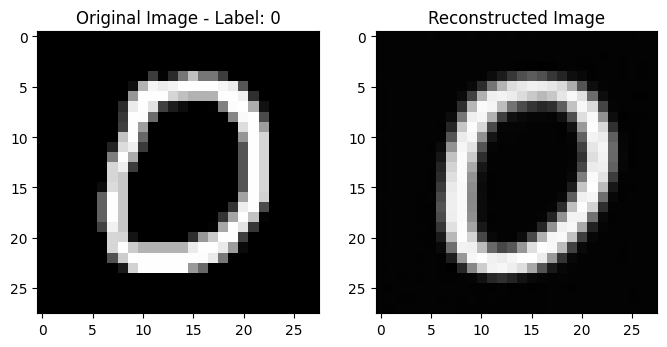

In [12]:
# Display numpy.ndarray image as plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(X_test[10], cmap="gray")
ax[0].set_title(f"Original Image - Label: {y_test[10]}")
ax[1].imshow(reconstructed_image, cmap="gray")
ax[1].set_title("Reconstructed Image")
plt.show()